# Entrenamiento de Modelo LSTM para Predicción de Temperatura
## Usando 3 features del dataset meteorológico

Este notebook entrena un modelo LSTM usando solo 3 columnas del `dataset_ml.csv`:

**Features seleccionadas:**
- **ts**: Temperatura del Aire Seco (°C) → **[OBJETIVO A PREDECIR]**
- **hr**: Humedad Relativa del aire (%)
- **p0**: Presión leída del sensor (hPa)

Este enfoque simplificado permite:
- ✅ Entrenamiento más rápido
- ✅ Modelo más ligero
- ✅ Fácil de mapear con datos de Arduino (temperatura, humedad, presión)
- ✅ Menos riesgo de overfitting

In [3]:
# Imports necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import joblib
import warnings
warnings.filterwarnings('ignore')

## 1. Cargar y explorar datos

In [5]:
# Cargar datos del dataset completo
csv_path = "dataset_ml.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

print(f"✅ Datos cargados")
print(f"   Total de registros: {len(df):,}")
print(f"   Columnas: {list(df.columns)}")
print(f"\n📊 Primeras filas:")
df.head(10)

✅ Datos cargados
   Total de registros: 20,730
   Columnas: ['momento', 'ts', 'td', 'tMin12Horas', 'tMax12Horas', 'tMin24Horas', 'hr', 'p0', 'qfe1', 'qfe2', 'qff', 'qnh', 'tPromedio24h', 'deltaTemp1h', 'deltaPresion1h', 'humedadRelativaCambio']

📊 Primeras filas:


,momento,ts,td,tMin12Horas,tMax12Horas,tMin24Horas,hr,p0,qfe1,qfe2,qff,qnh,tPromedio24h,deltaTemp1h,deltaPresion1h,humedadRelativaCambio
0,2019-01-01 01:00:00,21.9,3.5,21.0,32.3,32.9,30.0,950.9,951.0,951.184,1010.0,1011.9,22.683607,-1.7,0.5,1.2
1,2019-01-01 01:01:00,21.8,3.5,21.0,32.3,32.9,30.0,950.9,951.0,951.184,1010.0,1011.9,22.669355,-1.8,0.5,1.2
2,2019-01-01 01:02:00,21.8,3.5,21.0,32.3,32.9,30.0,950.9,951.2,951.184,1010.2,1012.1,22.655556,-1.8,0.5,1.0
3,2019-01-01 01:03:00,21.8,3.6,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.642187,-1.7,0.5,1.0
4,2019-01-01 01:04:00,21.8,3.5,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.629231,-1.7,0.5,0.9
5,2019-01-01 01:05:00,21.7,3.5,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.615152,-1.7,0.4,1.0
6,2019-01-01 01:06:00,21.7,3.3,21.0,32.3,32.9,29.7,950.9,951.0,951.184,1010.1,1011.9,22.601493,-1.7,0.4,0.8
7,2019-01-01 01:07:00,21.8,3.3,21.0,32.3,32.9,29.7,951.0,951.1,951.184,1010.1,1012.0,22.589706,-1.6,0.6,0.7
8,2019-01-01 01:08:00,21.8,3.3,21.0,32.3,32.9,29.9,951.0,951.1,951.184,1010.1,1012.0,22.578261,-1.6,0.5,1.0
9,2019-01-01 01:09:00,21.7,3.5,21.0,32.3,32.9,30.1,951.0,951.2,951.184,1010.2,1012.1,22.565714,-1.6,0.5,1.1


## 2. Preparar datos para el modelo

In [6]:
import pandas as pd
import numpy as np

# === USO DE 'momento' (ajuste mínimo y obligatorio) ===
df["momento"] = pd.to_datetime(df["momento"], errors='coerce')

# Convertir el instante a valor horario decimal (ejemplo: 13:30 = 13.5)
df["hora_decimal"] = df["momento"].dt.hour + df["momento"].dt.minute / 60.0

# Eliminar 'momento' original porque ya se convirtió a formato numérico
df = df.drop(columns=["momento"])

# === Seleccionar solo las columnas que necesitamos (más la hora_decimal) ===
feature_cols = ['ts', 'hr', 'p0', 'hora_decimal']

# Verificar que las columnas existan
missing = [col for col in feature_cols if col not in df.columns]
if missing:
    print(f"❌ Columnas faltantes: {missing}")
    print(f"   Columnas disponibles: {list(df.columns)}")
else:
    print(f"✅ Todas las columnas están disponibles")

# Extraer solo las columnas seleccionadas
df_selected = df[feature_cols].copy()

# Convertir a numérico y limpiar valores inválidos
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')
df_selected = df_selected.replace([np.inf, -np.inf], np.nan).dropna()

print(f"\n✅ Datos preparados")
print(f"   Registros después de limpieza: {len(df_selected):,}")
print(f"   Features seleccionadas: {feature_cols}")

# Extraer datos numéricos
data = df_selected.values
print(f"   Shape final: {data.shape}")


✅ Todas las columnas están disponibles

✅ Datos preparados
   Registros después de limpieza: 20,730
   Features seleccionadas: ['ts', 'hr', 'p0', 'hora_decimal']
   Shape final: (20730, 4)


In [7]:
# Estadísticas descriptivas de las 3 variables
print("📈 Estadísticas de las variables seleccionadas:")
df_selected.describe()

📈 Estadísticas de las variables seleccionadas:


,ts,hr,p0,hora_decimal
count,20730.000000,20730.000000,20730.000000,20730.000000
mean,20.181732,51.268476,953.988804,11.819814
std,5.737031,16.930859,2.788762,6.923424
min,9.000000,12.000000,947.800000,0.000000
25%,15.400000,38.900000,951.500000,5.816667
50%,19.350000,52.200000,954.400000,11.650000
75%,24.700000,64.400000,956.400000,17.816667
max,34.900000,91.900000,958.800000,23.983333


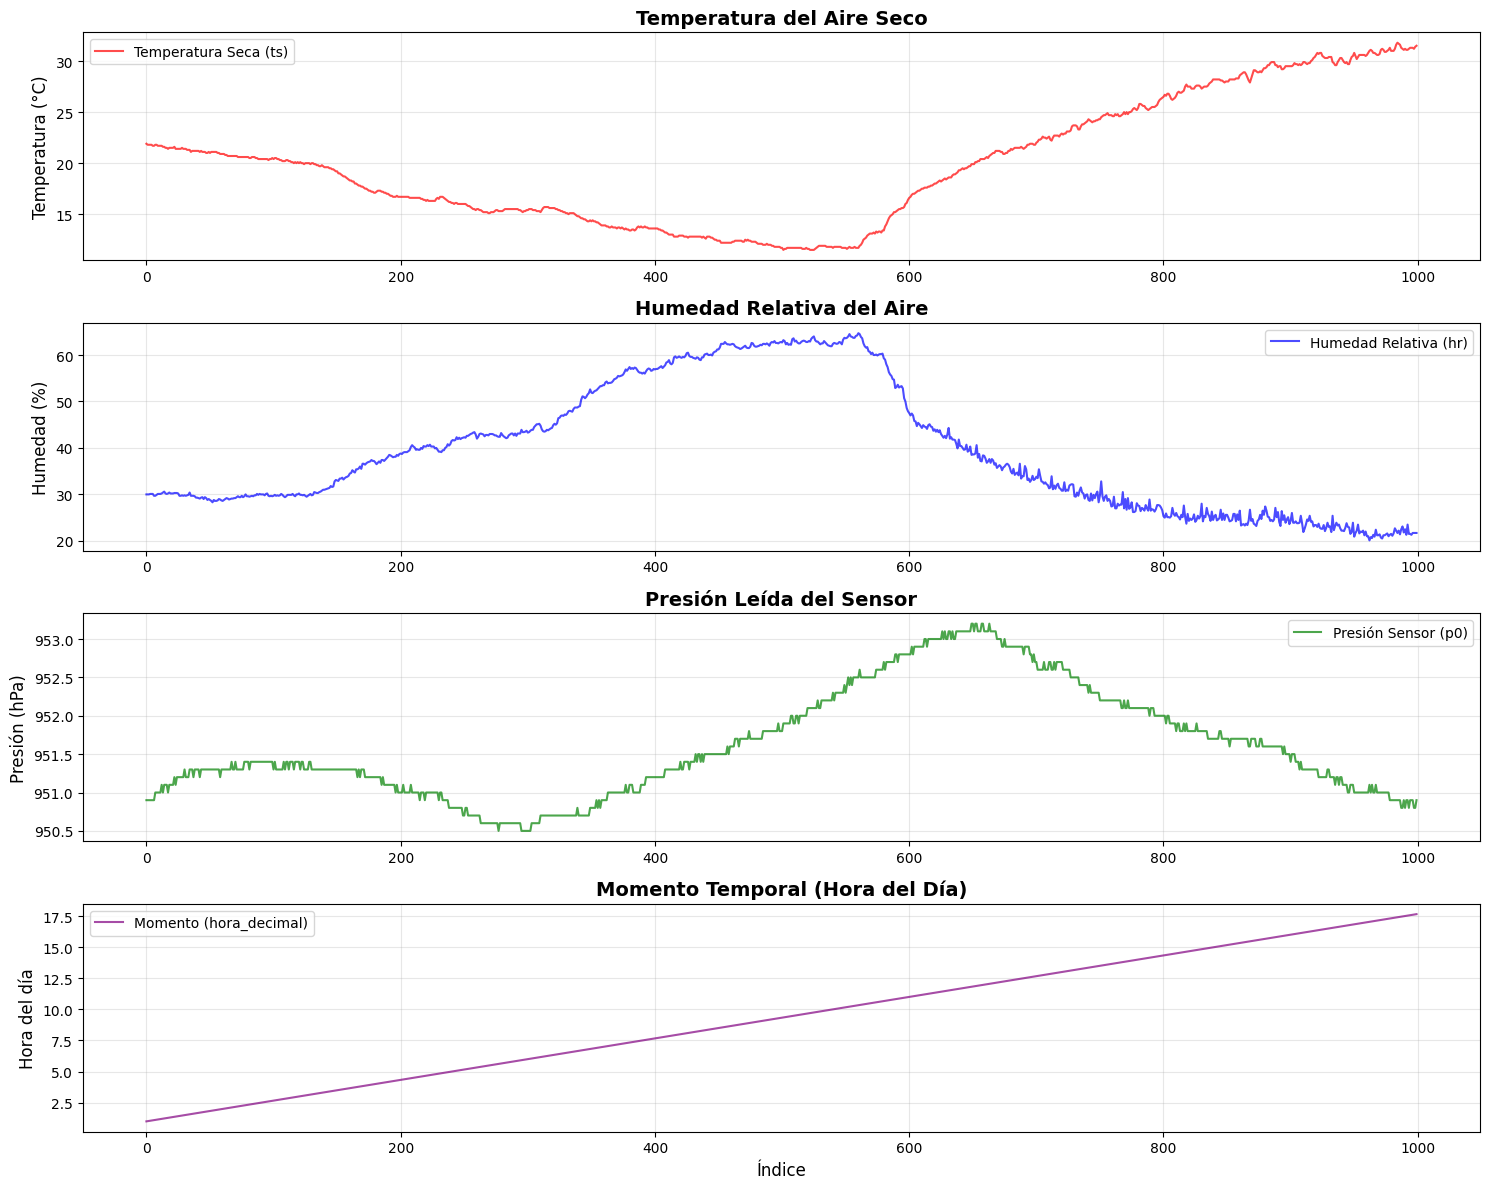

📊 Visualización de las primeras 1000 muestras de las 4 variables (incluyendo hora_decimal)


In [8]:
# Visualizar distribución de las 4 variables (ts, hr, p0, hora_decimal)
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Temperatura seca (ts)
axes[0].plot(df_selected['ts'][:1000], label='Temperatura Seca (ts)', color='red', alpha=0.7, linewidth=1.5)
axes[0].set_ylabel('Temperatura (°C)', fontsize=12)
axes[0].set_title('Temperatura del Aire Seco', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Humedad relativa (hr)
axes[1].plot(df_selected['hr'][:1000], label='Humedad Relativa (hr)', color='blue', alpha=0.7, linewidth=1.5)
axes[1].set_ylabel('Humedad (%)', fontsize=12)
axes[1].set_title('Humedad Relativa del Aire', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Presión (p0)
axes[2].plot(df_selected['p0'][:1000], label='Presión Sensor (p0)', color='green', alpha=0.7, linewidth=1.5)
axes[2].set_ylabel('Presión (hPa)', fontsize=12)
axes[2].set_title('Presión Leída del Sensor', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Hora decimal (momento del registro)
axes[3].plot(df_selected['hora_decimal'][:1000], label='Momento (hora_decimal)', color='purple', alpha=0.7, linewidth=1.5)
axes[3].set_ylabel('Hora del día', fontsize=12)
axes[3].set_xlabel('Índice', fontsize=12)
axes[3].set_title('Momento Temporal (Hora del Día)', fontsize=14, fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualización de las primeras 1000 muestras de las 4 variables (incluyendo hora_decimal)")


In [9]:
from sklearn.preprocessing import StandardScaler
import joblib

# Escalado con StandardScaler (ahora con las 4 features)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print("✅ Datos escalados con StandardScaler")
print(f"   Shape escalado: {data_scaled.shape}")
print(f"   Media de cada feature: {scaler.mean_}")
print(f"   Desviación estándar:   {scaler.scale_}")

# Guardar el scaler para uso futuro (nombre actualizado)
scaler_path = "scaler_4_features.pkl"
joblib.dump(scaler, scaler_path)
print(f"\n💾 Scaler guardado en: {scaler_path}")


✅ Datos escalados con StandardScaler
   Shape escalado: (20730, 4)
   Media de cada feature: [ 20.18173179  51.26847564 953.98880367  11.81981428]
   Desviación estándar:   [ 5.73689278 16.93045043  2.78869428  6.92325721]

💾 Scaler guardado en: scaler_4_features.pkl


## 3. Crear secuencias para LSTM

In [10]:
def crear_secuencias(datos, n_pasos, columna_objetivo=0):
    """
    Crea secuencias de tiempo para entrenar el LSTM.

    Args:
        datos: Array con los datos escalados (n_samples, n_features)
        n_pasos: Número de timesteps en cada secuencia
        columna_objetivo: Índice de la columna a predecir (0 = ts)

    Returns:
        X: Secuencias de entrada (n_sequences, n_pasos, n_features)
        y: Valores objetivo (n_sequences,) - temperatura del siguiente paso
    """
    X, y = [], []
    for i in range(n_pasos, len(datos)):
        X.append(datos[i - n_pasos:i])  # Ventana de n_pasos
        y.append(datos[i, columna_objetivo])  # Temperatura ts del siguiente paso
    return np.array(X), np.array(y)

# Configuración
n_pasos = 24  # Usar las últimas 24 observaciones para predecir la siguiente
columna_ts = 0  # ts sigue siendo la primera columna (índice 0)

# Crear secuencias con la nueva feature 'hora_decimal' incluida
X, y = crear_secuencias(data_scaled, n_pasos, columna_ts)

print(f"✅ Secuencias creadas")
print(f"   X shape: {X.shape} (secuencias, timesteps, features)")
print(f"   y shape: {y.shape} (secuencias,)")
print(f"   Timesteps: {n_pasos}")
print(f"   Features por timestep: {X.shape[2]} (ts, hr, p0, hora_decimal)")
print(f"   Prediciendo: ts (Temperatura del Aire Seco)")


✅ Secuencias creadas
   X shape: (20706, 24, 4) (secuencias, timesteps, features)
   y shape: (20706,) (secuencias,)
   Timesteps: 24
   Features por timestep: 4 (ts, hr, p0, hora_decimal)
   Prediciendo: ts (Temperatura del Aire Seco)


## 4. Dividir en entrenamiento y validación

In [11]:
# Dividir datos (80% entrenamiento, 20% validación)
split_ratio = 0.8
n_train = int(len(X) * split_ratio)

X_train, X_val = X[:n_train], X[n_train:]
y_train, y_val = y[:n_train], y[n_train:]

print(f"✅ División completada")
print(f"   Entrenamiento: {len(X_train):,} secuencias ({split_ratio*100:.0f}%)")
print(f"   Validación:    {len(X_val):,} secuencias ({(1-split_ratio)*100:.0f}%)")

✅ División completada
   Entrenamiento: 16,564 secuencias (80%)
   Validación:    4,142 secuencias (20%)


## 5. Construir el modelo LSTM

In [12]:
# Arquitectura del modelo LSTM
model = Sequential([
    # Primera capa LSTM con 128 unidades
    LSTM(128, return_sequences=True, input_shape=(n_pasos, X.shape[2])),  # X.shape[2] ahora = 4
    Dropout(0.2),

    # Segunda capa LSTM con 64 unidades
    LSTM(64, return_sequences=False),
    Dropout(0.2),

    # Capa de salida
    Dense(1)  # Predice 1 valor: temperatura del siguiente paso
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("✅ Modelo construido")
model.summary()

✅ Modelo construido


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,569 (459.25 KB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrenar el modelo

In [13]:
# === Callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'modelo_lstm_clima_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenamiento del modelo
print("🚀 Iniciando entrenamiento...\n")
history = model.fit(
    X_train, y_train,               # Secuencias con 4 features (ts, hr, p0, hora_decimal)
    validation_data=(X_val, y_val),
    epochs=50,                      # Ajustar según necesidad, 1 para prueba rápida
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\n✅ Entrenamiento completado")

🚀 Iniciando entrenamiento...

Epoch 1/50
517/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0490 - mae: 0.1315
Epoch 1: val_loss improved from inf to 0.00208, saving model to modelo_lstm_clima_best.h5


518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0489 - mae: 0.1314 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 2/50
514/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - mae: 0.0710
Epoch 2: val_loss did not improve from 0.00208
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0094 - mae: 0.0710 - val_loss: 0.0021 - val_mae: 0.0330
Epoch 3/50
512/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - mae: 0.0665
Epoch 3: val_loss improved from 0.00208 to 0.00139, saving model to modelo_lstm_clima_best.h5


518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0081 - mae: 0.0665 - val_loss: 0.0014 - val_mae: 0.0256
Epoch 4/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0648
Epoch 4: val_loss did not improve from 0.00139
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0079 - mae: 0.0648 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 5/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - mae: 0.0635
Epoch 5: val_loss did not improve from 0.00139
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0075 - mae: 0.0635 - val_loss: 0.0021 - val_mae: 0.0384
Epoch 6/50
511/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - mae: 0.0621
Epoch 6: val_loss improved from 0.00139 to 0.00134, saving model to modelo_lstm_clima_best.h5


518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0073 - mae: 0.0621 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 7/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - mae: 0.0626
Epoch 7: val_loss improved from 0.00134 to 0.00116, saving model to modelo_lstm_clima_best.h5


518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0077 - mae: 0.0626 - val_loss: 0.0012 - val_mae: 0.0229
Epoch 8/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0607
Epoch 8: val_loss did not improve from 0.00116
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0071 - mae: 0.0607 - val_loss: 0.0012 - val_mae: 0.0241
Epoch 9/50
517/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0595
Epoch 9: val_loss did not improve from 0.00116
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0069 - mae: 0.0595 - val_loss: 0.0013 - val_mae: 0.0255
Epoch 10/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - mae: 0.0588
Epoch 10: val_loss improved from 0.00116 to 0.00088, saving model to modelo_lstm_clima_best.h5


518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0067 - mae: 0.0588 - val_loss: 8.8024e-04 - val_mae: 0.0221
Epoch 11/50
514/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mae: 0.0602
Epoch 11: val_loss did not improve from 0.00088
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0072 - mae: 0.0602 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 12/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0580
Epoch 12: val_loss did not improve from 0.00088
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0065 - mae: 0.0580 - val_loss: 8.9354e-04 - val_mae: 0.0220
Epoch 13/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0576
Epoch 13: val_loss did not improve from 0.00088
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0065 - mae: 0.0576 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 14/50
512/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0577
Epoch 14: val_loss did not improve from 0.00088
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - l

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0065 - mae: 0.0576 - val_loss: 6.1583e-04 - val_mae: 0.0179
Epoch 17/50
514/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0571
Epoch 17: val_loss did not improve from 0.00062
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - mae: 0.0571 - val_loss: 7.6447e-04 - val_mae: 0.0200
Epoch 18/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0575
Epoch 18: val_loss improved from 0.00062 to 0.00058, saving model to modelo_lstm_clima_best.h5


518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0065 - mae: 0.0575 - val_loss: 5.8219e-04 - val_mae: 0.0171
Epoch 19/50
512/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - mae: 0.0568
Epoch 19: val_loss did not improve from 0.00058
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0064 - mae: 0.0568 - val_loss: 8.7343e-04 - val_mae: 0.0222
Epoch 20/50
517/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0569
Epoch 20: val_loss did not improve from 0.00058
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - mae: 0.0569 - val_loss: 0.0011 - val_mae: 0.0275
Epoch 21/50
513/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0562
Epoch 21: val_loss did not improve from 0.00058
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - mae: 0.0562 - val_loss: 7.7657e-04 - val_mae: 0.0228
Epoch 22/50
517/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - mae: 0.0566
Epoch 22: val_loss did not improve from 0.00058
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - mae: 0.0560 - val_loss: 5.4527e-04 - val_mae: 0.0169
Epoch 24/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - mae: 0.0547
Epoch 24: val_loss did not improve from 0.00055
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0059 - mae: 0.0547 - val_loss: 9.9011e-04 - val_mae: 0.0269
Epoch 25/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - mae: 0.0550
Epoch 25: val_loss did not improve from 0.00055
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0059 - mae: 0.0550 - val_loss: 6.1378e-04 - val_mae: 0.0187
Epoch 26/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0565
Epoch 26: val_loss did not improve from 0.00055
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - mae: 0.0565 - val_loss: 6.9995e-04 - val_mae: 0.0216
Epoch 27/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - mae: 0.0549
Epoch 27: val_loss did not improve from 0.00055
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0066 - mae: 0.0575 - val_loss: 5.2860e-04 - val_mae: 0.0170
Epoch 29/50
512/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - mae: 0.0555
Epoch 29: val_loss did not improve from 0.00053
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0061 - mae: 0.0555 - val_loss: 6.1603e-04 - val_mae: 0.0189
Epoch 30/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - mae: 0.0555
Epoch 30: val_loss did not improve from 0.00053
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0062 - mae: 0.0555 - val_loss: 5.7871e-04 - val_mae: 0.0190
Epoch 31/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - mae: 0.0551
Epoch 31: val_loss did not improve from 0.00053
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0061 - mae: 0.0551 - val_loss: 8.8265e-04 - val_mae: 0.0230
Epoch 32/50
510/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - mae: 0.0555
Epoch 32: val_loss improved from 0.00053 to 0.00043, saving model to modelo_lstm_cli

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0061 - mae: 0.0554 - val_loss: 4.3334e-04 - val_mae: 0.0151
Epoch 33/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0536
Epoch 33: val_loss did not improve from 0.00043
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0057 - mae: 0.0536 - val_loss: 4.6641e-04 - val_mae: 0.0158
Epoch 34/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0545
Epoch 34: val_loss did not improve from 0.00043
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0060 - mae: 0.0545 - val_loss: 4.4533e-04 - val_mae: 0.0160
Epoch 35/50
513/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - mae: 0.0538
Epoch 35: val_loss did not improve from 0.00043
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0057 - mae: 0.0538 - val_loss: 6.5053e-04 - val_mae: 0.0195
Epoch 36/50
511/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mae: 0.0538
Epoch 36: val_loss did not improve from 0.00043
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0059 - mae: 0.0543 - val_loss: 4.2311e-04 - val_mae: 0.0153
Epoch 42/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0542
Epoch 42: val_loss did not improve from 0.00042
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0060 - mae: 0.0542 - val_loss: 8.6631e-04 - val_mae: 0.0246
Epoch 43/50
513/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0542
Epoch 43: val_loss did not improve from 0.00042
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0059 - mae: 0.0542 - val_loss: 6.6533e-04 - val_mae: 0.0214
Epoch 44/50
514/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mae: 0.0540
Epoch 44: val_loss did not improve from 0.00042
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0058 - mae: 0.0540 - val_loss: 0.0010 - val_mae: 0.0250
Epoch 45/50
513/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mae: 0.0541
Epoch 45: val_loss did not improve from 0.00042
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0057 - mae: 0.0535 - val_loss: 3.7574e-04 - val_mae: 0.0138
Epoch 48/50
514/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mae: 0.0539
Epoch 48: val_loss did not improve from 0.00038
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0058 - mae: 0.0539 - val_loss: 4.1725e-04 - val_mae: 0.0154
Epoch 49/50
515/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mae: 0.0538
Epoch 49: val_loss did not improve from 0.00038
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0058 - mae: 0.0538 - val_loss: 5.5267e-04 - val_mae: 0.0170
Epoch 50/50
516/518 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - mae: 0.0533
Epoch 50: val_loss did not improve from 0.00038
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0056 - mae: 0.0533 - val_loss: 9.9335e-04 - val_mae: 0.0270
Restoring model weights from the end of the best epoch: 47.

✅ Entrenamiento completado


## 7. Visualizar resultados del entrenamiento

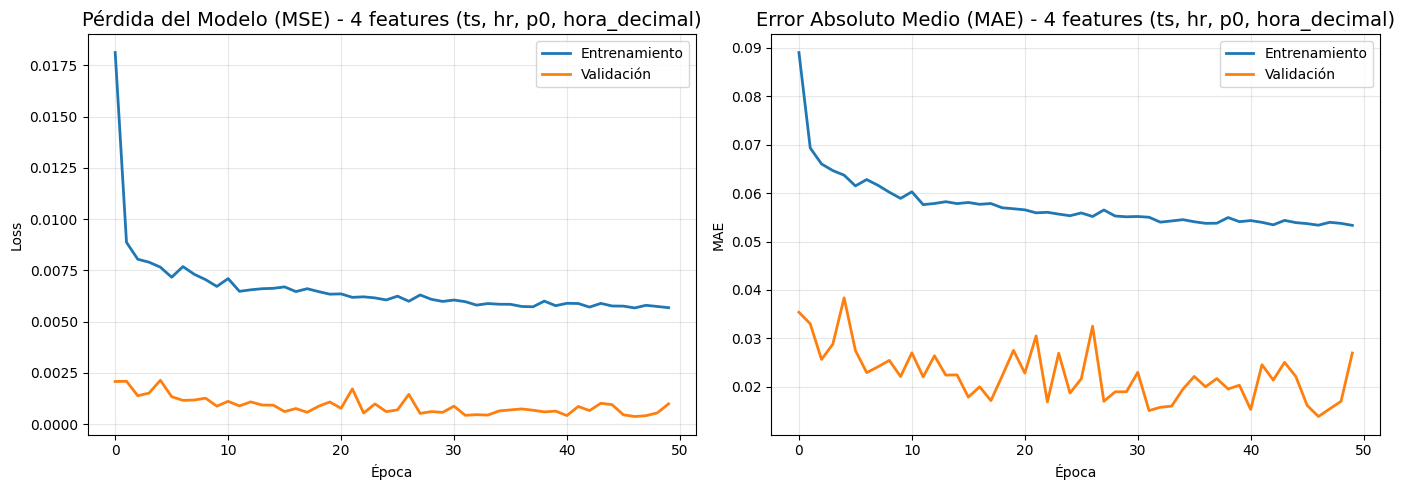

In [24]:
# Graficar pérdida y MAE del entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss (MSE)
axes[0].plot(history.history['loss'], label='Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validación', linewidth=2)
axes[0].set_title('Pérdida del Modelo (MSE) - 4 features (ts, hr, p0, hora_decimal)', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validación', linewidth=2)
axes[1].set_title('Error Absoluto Medio (MAE) - 4 features (ts, hr, p0, hora_decimal)', fontsize=14)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Evaluar el modelo

In [17]:
# Evaluar en conjunto de validación
loss, mae = model.evaluate(X_val, y_val, verbose=0)

print(f"📊 RESULTADOS EN VALIDACIÓN")
print(f"   Loss (MSE): {loss:.6f}")
print(f"   MAE:        {mae:.6f}")

# Hacer predicciones en validación
y_pred_scaled = model.predict(X_val, verbose=0)

# Invertir escalado para obtener temperaturas reales
# Crear array dummy con las 3 features
dummy_pred = np.zeros((len(y_pred_scaled), 4))
dummy_pred[:, 0] = y_pred_scaled.flatten()  # ts en columna 0
y_pred_real = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(y_val), 4))
dummy_true[:, 0] = y_val
y_true_real = scaler.inverse_transform(dummy_true)[:, 0]

# Calcular MAE en escala real
mae_real = np.mean(np.abs(y_pred_real - y_true_real))
print(f"\n🌡️  MAE en escala real: {mae_real:.3f} °C")

📊 RESULTADOS EN VALIDACIÓN
   Loss (MSE): 0.000376
   MAE:        0.013845

🌡️  MAE en escala real: 0.079 °C


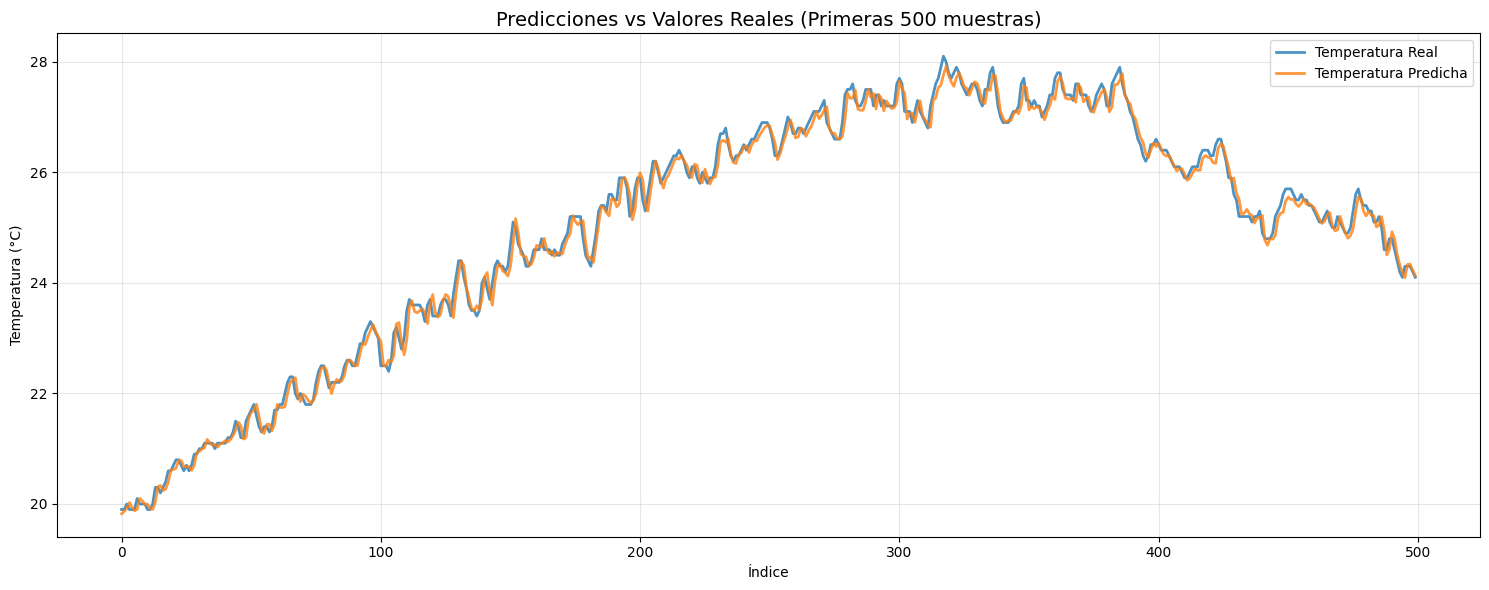

📊 Gráfica de comparación generada


In [18]:
# Visualizar predicciones vs valores reales
n_samples = 500  # Mostrar solo las primeras 500 predicciones

plt.figure(figsize=(15, 6))
plt.plot(y_true_real[:n_samples], label='Temperatura Real', linewidth=2, alpha=0.8)
plt.plot(y_pred_real[:n_samples], label='Temperatura Predicha', linewidth=2, alpha=0.8)
plt.title(f'Predicciones vs Valores Reales (Primeras {n_samples} muestras)', fontsize=14)
plt.xlabel('Índice')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Gráfica de comparación generada")

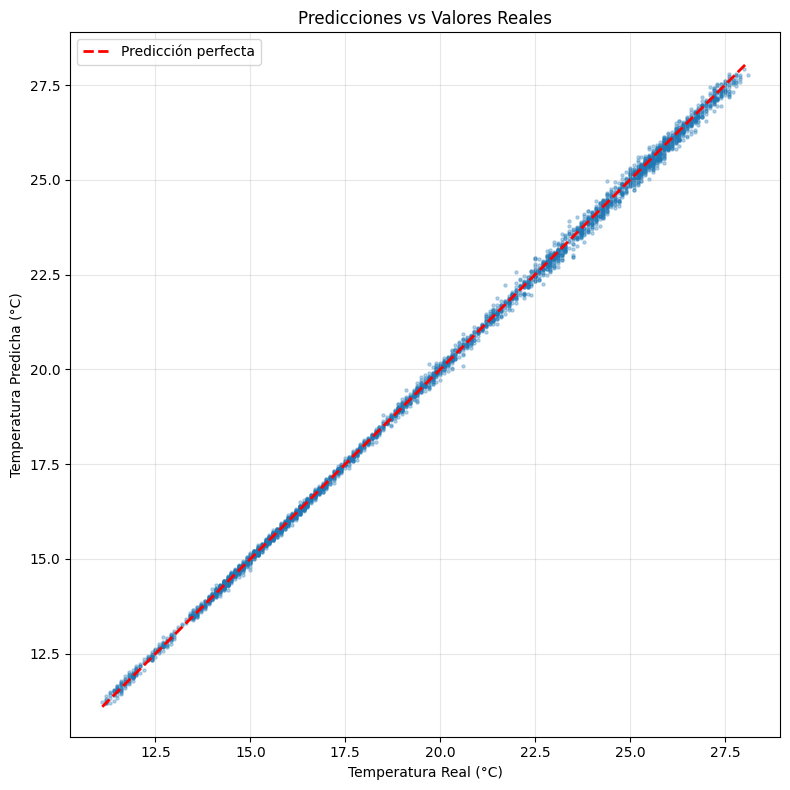

In [19]:
# Scatter plot: predicho vs real
plt.figure(figsize=(8, 8))
plt.scatter(y_true_real[:5000], y_pred_real[:5000], alpha=0.3, s=5)
plt.plot([y_true_real.min(), y_true_real.max()],
         [y_true_real.min(), y_true_real.max()],
         'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 9. Predicción futura

In [22]:
# Usar la última ventana disponible para predecir el siguiente valor
ultima_ventana = data_scaled[-n_pasos:].reshape(1, n_pasos, 4)

# Predecir
siguiente_pred_scaled = model.predict(ultima_ventana, verbose=0)[0][0]

# Invertir escalado
dummy_siguiente = np.zeros((1, 4))
dummy_siguiente[0, 0] = siguiente_pred_scaled
siguiente_temp = scaler.inverse_transform(dummy_siguiente)[0, 0]

ultima_temp_real = df_selected['ts'].iloc[-1]

print(f"🔮 PREDICCIÓN DEL SIGUIENTE PASO")
print(f"   Última temperatura real (ts):    {ultima_temp_real:.2f} °C")
print(f"   Temperatura predicha:            {siguiente_temp:.2f} °C")
print(f"   Diferencia:                      {siguiente_temp - ultima_temp_real:+.2f} °C")

🔮 PREDICCIÓN DEL SIGUIENTE PASO
   Última temperatura real (ts):    11.60 °C
   Temperatura predicha:            11.63 °C
   Diferencia:                      +0.03 °C


## 10. Guardar modelo final

In [23]:
# Guardar el modelo final
model_path = "modelo_lstm_3_features.h5"
model.save(model_path)

print(f"✅ ARCHIVOS GUARDADOS:")
print(f"   📦 Modelo:  {model_path}")
print(f"   📦 Scaler:  {scaler_path}")
print(f"\n🎉 ¡Entrenamiento completado exitosamente!")
print(f"\n📝 Configuración del modelo:")
print(f"   - Dataset:    dataset_ml.csv")
print(f"   - Features:   3 columnas (ts, hr, p0)")
print(f"   - Timesteps:  {n_pasos}")
print(f"   - MAE:        {mae_real:.3f} °C")
print(f"   - Objetivo:   Predecir 'ts' (Temperatura del Aire Seco)")
print(f"\n💡 Ahora puedes usar el modelo con 'predecir_simple.py'")

✅ ARCHIVOS GUARDADOS:
   📦 Modelo:  modelo_lstm_3_features.h5
   📦 Scaler:  scaler_4_features.pkl

🎉 ¡Entrenamiento completado exitosamente!

📝 Configuración del modelo:
   - Dataset:    dataset_ml.csv
   - Features:   3 columnas (ts, hr, p0)
   - Timesteps:  24
   - MAE:        0.079 °C
   - Objetivo:   Predecir 'ts' (Temperatura del Aire Seco)

💡 Ahora puedes usar el modelo con 'predecir_simple.py'
